# Getting MODIS data from Python

This notebook presents how to download MODIS data and stitch it together. As an example, we'll be looking at stitching some NDVI data over Ghana. There are 24 observations and we'll use the 0.05 degree product for this, [MOD13C1.006](https://lpdaac.usgs.gov/products/mod13c1v006/). The following code imports some relevant pacakges, as well as downloading some useful vector data with country boundaries. We'll use the latter to "clip" a country from the MODIS data.

In [1]:
from pathlib import Path
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import gdal
import ipywidgets

import requests

countries = Path('data/ne_50m_admin_0_countries.zip')
if not countries.exists():
    print("Downloading countries dataset...")
    with countries.open(mode="wb") as f:
        r = requests.get("https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_0_countries.zip")
        f.write(r.content)

    

The next snippet allows you to download MODIS data. Ghana stradlles four MODIS tiles, and in the next bit, you can download the data for a year (2018 in this case) and for product "MOD13A2.006", the 1KM NDVI/EVI dataset. This may take a bit, as it's quite a bit of data.

You'll need to provide your NASA EarthData login details, and set `bothered=True` to actually download the data.

In [3]:
from modis_downloader import get_modis_data
username = "USERNAME"
password = "PASSWORD"

bothered = False

if bothered:
    product = "MOD13A2.006"
    # You need four tiles to cover the entire Ghana
    tiles = ["h17v07", "h18v08", "h17v08", "h18v07"]
    get_modis_data(
            username,
            password,
            "MOLT",
            product,
            tiles,
            "./data/",
            dt.datetime(2018, 1, 1),
            end_date=dt.datetime(2018,12,31),
            n_threads=2,
        )
import logging
logging.getLogger().setLevel(logging.INFO)

Each HDF file has a number of datasets inside it (think of it as of a zipfile). We want to access the NDVI, and in order to use the GDAL library to do this, we need to access the following GDAL-name:

```HDF4_EOS:EOS_GRID:"data/MOD13A2.A2018129.h18v08.006.2018151110335.hdf":MODIS_Grid_16DAY_1km_VI:"1 km 16 days NDVI"'
```
We can see the actual HDF filename between the double quotes (with the path). The rest just refers to how GDAL accesses the data. The MODIS data are georreferenced, and provided in MODIS sinusoidal, which while equal area and global, it's not too convenient. 

The next stage is to mosaic togather all the files for a given date and then re-project them to e.g. WGS-84 (lat/long or Plate Carrée projection).

In [4]:
def mosaic_dates_wgs84(year, doy, folder="data", product="MOD13A2"):
    """Searches for all files in folder `folder` of a given MODIS product for
    the selected year and day of year, and mosaics them together. Returns the
    actual raster data, as well as the corner coordinates in WGS-84 projection.
    """
    files = [f'HDF4_EOS:EOS_GRID:"{f.as_posix():s}":MODIS_Grid_16DAY_1km_VI:"1 km 16 days NDVI"'
                 for f in Path(folder).glob(f"{product:s}.A{year:04d}{doy:03d}.*hdf")]
    g = gdal.Warp("", files,format="MEM",dstSRS="EPSG:4326")
    ndvi = g.ReadAsArray()
    geoT = g.GetGeoTransform()
    nx, ny = g.RasterXSize, g.RasterYSize
    ulx = geoT[0]
    uly = geoT[3]
    lrx = geoT[0] + nx*geoT[1]
    lry = geoT[3] + ny*geoT[5]
    return ndvi, ulx, uly, lrx, lry

We'll plot the time series over 2018 together with some country boundaries and whatnot

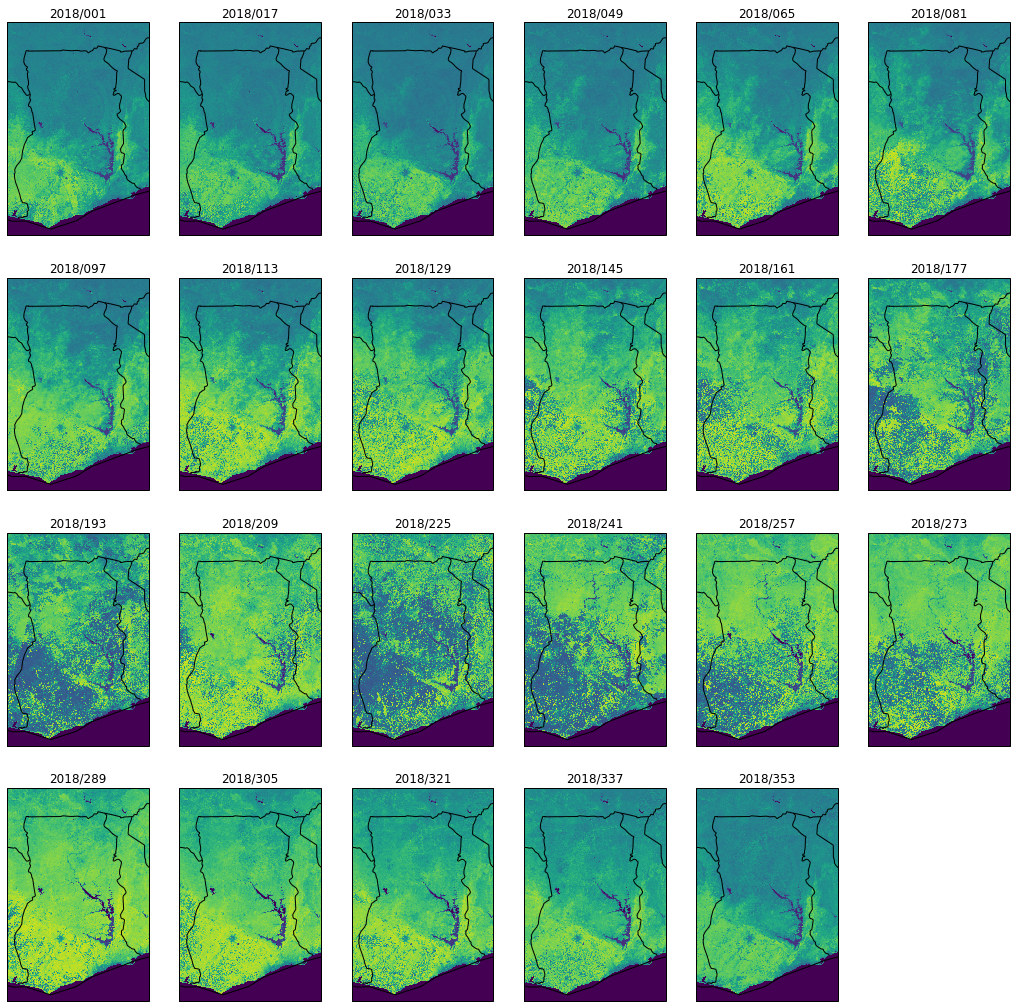

In [5]:


states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='50m',
        facecolor='none')

fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(18, 18), squeeze=True,
                       subplot_kw={'projection': ccrs.PlateCarree(),
                                   'extent':[-3.5,1.5,4.5,12]})
axs = axs.flatten()

for ii,doy in enumerate(range(1,354,16)):
    ndvi, ulx, uly,lrx, lry = mosaic_dates_wgs84(2018, doy)
    axs[ii].imshow(ndvi, origin="upper", extent=[ulx, lrx, lry, uly])
    axs[ii].set_extent([-3.5,1.5,4.5,12])
    axs[ii].add_feature(cfeature.LAND)
    axs[ii].add_feature(cfeature.COASTLINE)
    axs[ii].add_feature(states_provinces, edgecolor='black')
    axs[ii].set_title(f"2018/{doy:03d}")
axs[-1].set_visible(False)

Pretty neat... But what if we want to clip the MODIS data to cover only Ghana? We can use a shapefile to do this...

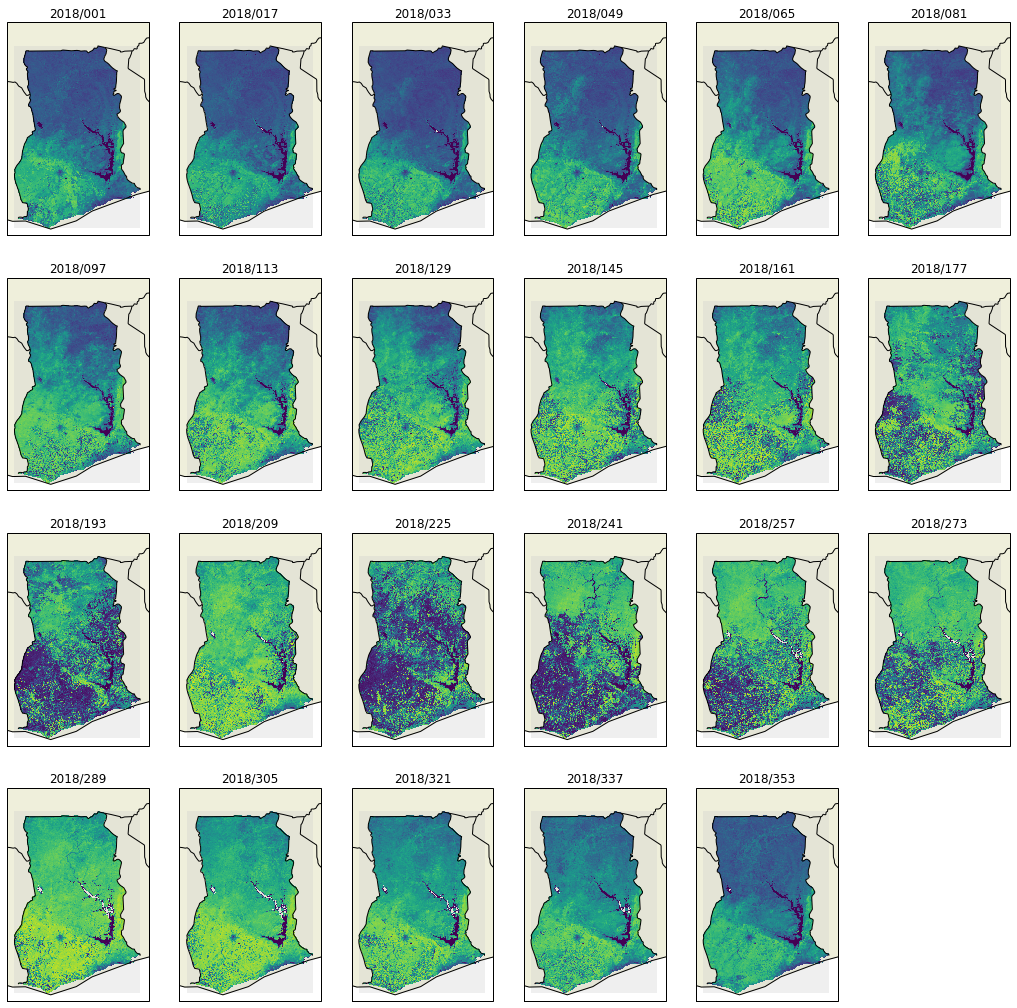

In [6]:

    
def mosaic_dates_wgs84_country(year, doy, folder="data", 
                               product="MOD13A2", country="Ghana",
                              srs="EPSG:4326", fmt="MEM"):
    """Searches for all files in folder `folder` of a given MODIS product for
    the selected year and day of year, and mosaics them together, clipping by some
    shapefile. Returns the actual raster data, as well as the corner coordinates in 
    WGS-84 projection.
    """
    files = [f'HDF4_EOS:EOS_GRID:"{f.as_posix():s}":MODIS_Grid_16DAY_1km_VI:"1 km 16 days NDVI"'
         for f in Path(folder).glob(f"{product:s}.A{year:04d}{doy:03d}.*hdf")]
    g = gdal.Warp("", files,format=fmt,dstSRS=srs,
                 cutlineDSName="/vsizip/data/ne_50m_admin_0_countries.zip",
                 cutlineWhere=f"NAME='{country:s}'",cropToCutline=True)
                 
    ndvi = g.ReadAsArray()
    geoT = g.GetGeoTransform()
    nx, ny = g.RasterXSize, g.RasterYSize
    ulx = geoT[0]
    uly = geoT[3]
    lrx = geoT[0] + nx*geoT[1]
    lry = geoT[3] + ny*geoT[5]
    return ndvi, ulx, uly, lrx, lry

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='50m',
        facecolor='none')

fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(18, 18), squeeze=True,
                       subplot_kw={'projection': ccrs.PlateCarree(),
                                   'extent':[-9,-2,0,11]})
axs = axs.flatten()
cmap = plt.cm.viridis
cmap.set_bad("0.8", alpha=0.3)
for ii,doy in enumerate(range(1,354,16)):
    ndvi, ulx, uly,lrx, lry = mosaic_dates_wgs84_country(2018, doy)
    ndvi = ndvi/10000.
    ndvi[ndvi<-0.2] = np.nan
    im = axs[ii].imshow(ndvi, vmin=0, vmax=1, origin="upper", extent=[ulx, lrx, lry, uly])
    axs[ii].set_extent([-3.5,1.5,4.5,12])
    axs[ii].add_feature(cfeature.LAND)
    axs[ii].add_feature(cfeature.COASTLINE)
    axs[ii].add_feature(states_provinces, edgecolor='black')
    axs[ii].set_title(f"2018/{doy:03d}")
axs[-1].set_visible(False)


If we are not too bothered about putting other datasets on top, we can also reproject to another projection (e.g. the [Accra/Ghana national grid](https://spatialreference.org/ref/epsg/2136/), given by EPSG code 2136). In this case, we'll just use matplotlib imshow to plot the data:

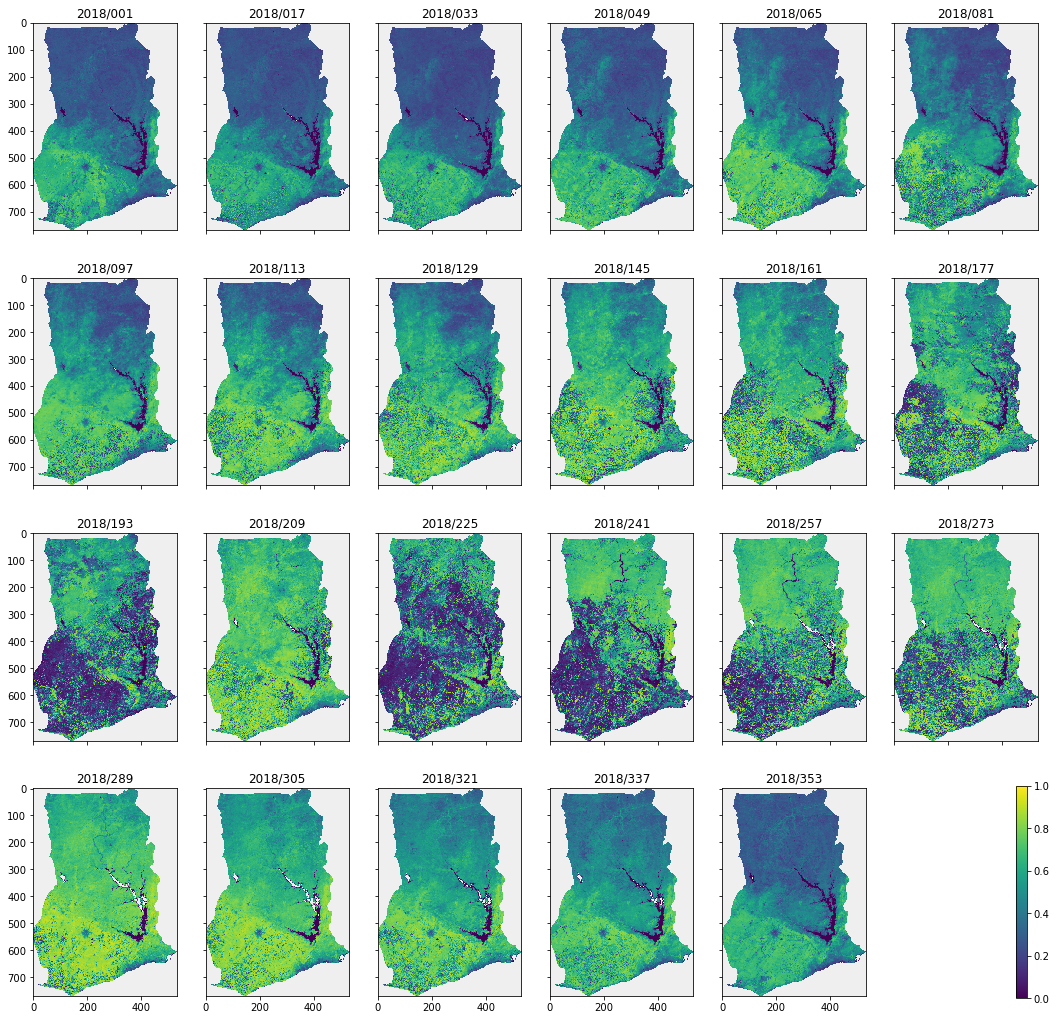

In [7]:

fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(18, 18), 
                        sharex=True, sharey=True,squeeze=True)
axs = axs.flatten()
cmap = plt.cm.viridis
cmap.set_bad("0.8", alpha=0.3)
for ii,doy in enumerate(range(1,354,16)):
    ndvi, ulx, uly,lrx, lry = mosaic_dates_wgs84_country(2018, doy, 
                                                         country="Ghana", srs="EPSG:2136")
    ndvi = ndvi/10000.
    ndvi[ndvi<-0.2] = np.nan
    im = axs[ii].imshow(ndvi, vmin=0, vmax=1, origin="upper")
    axs[ii].set_title(f"2018/{doy:03d}")

fig.colorbar(im)
axs[-1].set_visible(False)


Let's plot things interactively so we can slide over dates and see what's changing...

In [8]:
ndvi_annual = {doy:mosaic_dates_wgs84_country(2018, doy,country="Ghana", srs="EPSG:2136")[0]
               for doy in range(1, 360, 16)}
doys = [doy for doy in range(1, 360, 16)]

In [9]:
from ipywidgets import interact, widgets

def browse_images(images):
    N = len(images.keys())
    def view_image(doy=1):
        plt.figure(figsize=(7,10))
        plt.imshow(images[doy]/10000., interpolation="nearest",vmin=0, vmax=1, cmap=cmap)
        plt.title(f'Date {doy:d}')
    interact(view_image, doy=widgets.IntSlider(value=1, min=1, max=353, step=16))
    
browse_images(ndvi_annual)


interactive(children=(IntSlider(value=1, description='doy', max=353, min=1, step=16), Output()), _dom_classes=…